ANN

In [ ]:
!pip install surprise

In [ ]:
!pip install annoy

In [ ]:
from surprise import Dataset, SVD, Reader,NMF
from surprise.model_selection import cross_validate,train_test_split
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from surprise import accuracy
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval
import sys
import seaborn as sns
from timeit import Timer
from datetime import datetime
from surprise import Dataset, SVD, Reader,NMF
from surprise.model_selection import cross_validate,train_test_split
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from surprise import accuracy
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval
from collections import defaultdict
import random
from sklearn.metrics import mean_squared_error
from numpy.linalg import inv
import pandas as pd
import numpy as np
import math
from numpy.linalg import inv
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/data/sample_data.csv')

In [ ]:
data.drop(columns=['Unnamed: 0','timestamp','date','year'],inplace=True)
data

,userId,movieId,rating
0,2,849,3.5
1,339,849,5.0
2,1707,849,2.5
3,2040,849,1.0
4,2759,849,4.0
...,...,...,...
897059,279416,4090,4.0
897060,279765,4090,3.0
897061,279869,4090,3.0
897062,280137,4090,3.0


## Splitting Main dataset to a train and a test dataset

In [ ]:
user_freq=data.groupby(['userId']).size().reset_index(name='counts')
users_lt3=user_freq[user_freq['counts']<3][['userId']]
users_ge3=user_freq[user_freq['counts']>=3][['userId']]
train1 = pd.merge(data, users_lt3, on=['userId'],how='inner')
data1 = pd.merge(data, users_ge3, on=['userId'],how='inner')
random.seed(2)
test=data1.groupby('userId').sample(frac=.3, random_state=2)
test_idx = data1.index.isin(test.index.to_list())
train = train1.append(data1[~test_idx])


train_df = train
test_df = test

## Splitting Train data to a train and validation dataset for Hyperparameter Optimization of Annoy (ANN)

In [ ]:
user_freq1 = data.groupby(['userId']).size().reset_index(name='counts')

users_lt2=user_freq1[user_freq1['counts']<2][['userId']]
users_ge2=user_freq1[user_freq1['counts']>=2][['userId']]
train2 = pd.merge(train, users_lt2, on=['userId'],how='inner')
data2 = pd.merge(train, users_ge2, on=['userId'],how='inner')
random.seed(2)

validation = data2.groupby('userId').sample(frac=0.2, random_state=5)
validation_idx = data2.index.isin(validation.index.to_list())
train_data = train2.append(data2[~validation_idx])

##  Before Applying ANN, it is a prerequisite that we have our latent matrix i.e. U and V matrices ready.
Therefore, I am reusing code from the SVD Collaborative Filtering model to get the latent matrix.

In [ ]:
reader = Reader(rating_scale=(1,5))
train = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)
test = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader=reader)
raw_ratings = test.raw_ratings
threshold = int(1 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]

test = test.construct_testset(A_raw_ratings)

In [ ]:
raw_ratings1 = train.raw_ratings
threshold = int(1 * len(raw_ratings1))
B_raw_ratings = raw_ratings1[:threshold]
train_test = train.construct_testset(B_raw_ratings)

The hyperparameters are taken from the hyperparameter optimization performed in homework 2

In [ ]:
model = SVD(n_epochs=50,n_factors=15,reg_all=0.1,lr_all=0.02)
trainset = train.build_full_trainset()
model.fit(trainset)

In [ ]:
# Retrieiving inner ids, as used by surprise package during model training
user_inner_ids = [x for x in trainset.all_users()]
item_inner_ids = [i for i in trainset.all_items()]

# All ids mapped back to values in the actual train set 
user_raw_ids = [trainset.to_raw_uid(x) for x in user_inner_ids]
item_raw_ids = [trainset.to_raw_iid(x) for x in item_inner_ids]

print(user_raw_ids[:5])
print(item_raw_ids[:5])

[16421, 260732, 102234, 115586, 137983]
[849, 2746, 256, 1186, 45447]


In [ ]:
U = model.pu 
V = model.qi
print(U[0])
print(V[0])

[-0.2766652   0.05129945  0.02482979  0.14175177 -0.03045088 -0.06725312
 -0.15028632 -0.09776681 -0.09589824 -0.03254704 -0.07360083 -0.04562828
  0.20186044 -0.01711213  0.22403736]
[-0.23008582  0.27722892  0.11150006  0.05654918  0.18898329 -0.25740454
  0.08487099 -0.55804598  0.1612683   0.05774241  0.14376097 -0.62298298
  0.25338719  0.26446005  0.50896676]


In [ ]:
print(model.pu.shape) # (n_user, n_factors)
print(model.qi.shape) # (n_items, n_factors)

(20974, 15)
(1103, 15)


# Exploratory Data Analysis

### Movie frequency per user for all users in our training dataset

In [ ]:
user_freq = train_df.groupby('userId', as_index=False).agg(num_movies=('movieId','count'))

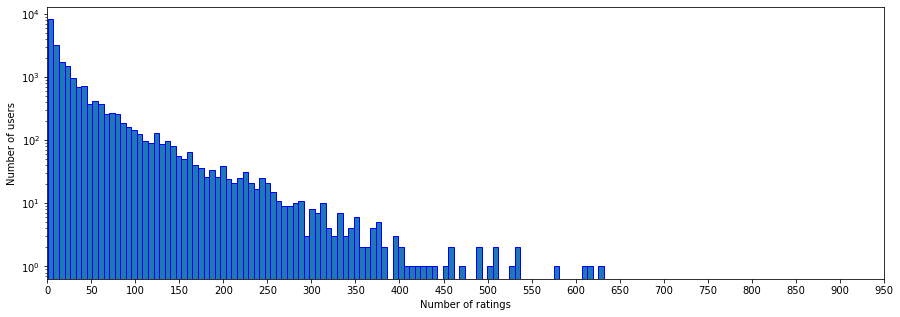

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,1000,50))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()


We have a lot of users who have rated more than 50 ratings.
We will be looking at using nearest neighbours to reduce the size of the the user-movie pairs in the train dataset.

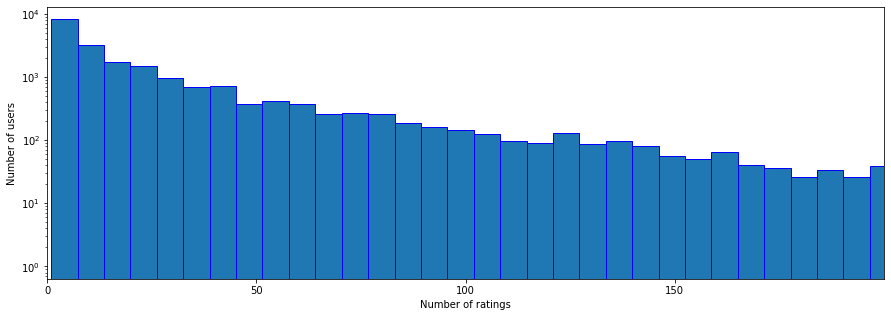

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,200)
plt.xticks(np.arange(0,200,50))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

The latent matrix is a numpy array of shape (n_items, n_factors. The first raw corresponds to the first raw item id (see this: http://surprise.readthedocs.io/en/latest/FAQ.html#what-are-raw-and-inner-ids), the second correspond to the second raw item id, etc...

# Annoy package 

Annoy is a C++ library with Python bindings that builds random projection trees. An index is built with a forest of k trees, where k is a tunable parameter that trades off between precision and performance. It also creates large read-only, file-based data structures that are mapped into memory so that many processes can share the data.

In [ ]:
from annoy import AnnoyIndex

HYPERPARAMETER OPTIMIZATION FOR ANN (FINDING THE OPTIMUM NUMBER OF TREES)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def filter_nn_user(nn_sim, movie_id,movie_to_users): 
    if nn_sim[0] in movie_to_users[movie_id]:
      return True
    return False

In [ ]:
def calc_raw_uid(inner_id):
  return trainset.to_raw_uid(inner_id)

In [ ]:
def calc_cosine(dist):
  return 1 - (dist/2)

In [ ]:
def Ann_predictions(train, test, n):
  train_users = train['userId'].unique()
  train_df_pivoted = train.pivot(index='userId', columns='movieId', values='rating')

  # Finding the average rating value per user
  avg_value = train_df_pivoted.mean(axis=1)
  user_mean_df = pd.DataFrame(avg_value,columns=['mean'])

  # Subtracting the average rating value from all the ratings of a user
  train_df_centered = train_df_pivoted.sub(train_df_pivoted.mean(axis=1), axis=0)

  movie_to_users = defaultdict(list)
  movie_to_users = train.groupby('movieId')['userId'].apply(list).to_dict()

  # Building Annoy Trees

  f = 15 # n_factors

  model_user_nn = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
  for i,u in zip(user_inner_ids,U):
      model_user_nn.add_item(i, u)

  model_user_nn.build(n) # n trees 
  # model_user_nn.save('test_user.ann')

  # Finding the 100 nearest neighbors to a user
  def find_nn(user_id):
    return model_user_nn.get_nns_by_item(trainset.to_inner_uid(user_id), 101, include_distances=True)
  
  l = list(map(find_nn,train_users))

  matrix_similarity_with_nn = {}


  # Filling in similar users and their distances to all users 
  for user_id,nn_dist in zip(train_users,l):
    matrix_similarity_with_nn[user_id] = [(nn,sim) for nn,sim in zip(list(map(calc_raw_uid,nn_dist[0]))[1:],list(map(calc_cosine,nn_dist[1]))[1:])]

  # Prediction function to predict ratings for all user-movie pair in test/validation dataset 
  def predict_nn_rating(user_movie_pair):
    user_id, movie_id = user_movie_pair
    reduced_nn_sim = pd.DataFrame(filter(lambda x: filter_nn_user(x, movie_id, movie_to_users),matrix_similarity_with_nn[user_id]))
    prediction = user_mean_df.loc[user_id].values[0]

    if len(reduced_nn_sim)==0:
      return prediction

    u_list = reduced_nn_sim[0].to_list()
    nr = np.dot(train_df_centered.loc[u_list][movie_id],reduced_nn_sim[1])
    dr = np.sum(np.abs(reduced_nn_sim[1]))
    if(dr!=0):
      prediction += (nr/dr)
    return prediction


  preds = list(map(predict_nn_rating,[(user_id,movie_id) for user_id, movie_id in zip(test['userId'],test['movieId'])]))
  rmse = np.sqrt(mean_squared_error(test['rating'],preds))
  return rmse


In [ ]:
rmse_validation = {}
rmse_validation[10] = Ann_predictions(train_data,validation,10)
rmse_validation[15] = Ann_predictions(train_data,validation,15)
rmse_validation[20] = Ann_predictions(train_data,validation,20)

df1 = pd.DataFrame(list(rmse_validation.items()),columns = ['num_of_trees','RMSE'])
df1.to_csv('/data/hyperparameters_rmse.csv')

In [ ]:
rmse_validation = {}
rmse_validation[25] = Ann_predictions(train_data,validation,25)
rmse_validation[50] = Ann_predictions(train_data,validation,50)
rmse_validation[80] = Ann_predictions(train_data,validation,80)
df2 = pd.DataFrame(list(rmse_validation.items()),columns = ['num_of_trees','RMSE'])
df2.to_csv('/data/hyperparameters_rmse2.csv')

In [ ]:
rmse_validation = {}
rmse_validation[60] = Ann_predictions(train_data,validation,60)
rmse_validation[70] = Ann_predictions(train_data,validation,70)
rmse_validation[90] = Ann_predictions(train_data,validation,90)

df3 = pd.DataFrame(list(rmse_validation.items()),columns = ['num_of_trees','RMSE'])
df3.to_csv('/data/hyperparameters_rmse_3.csv')

In [ ]:
df1 = pd.read_csv("/data/hyperparameters_rmse.csv") 
df2 = pd.read_csv("/data/hyperparameters_rmse2.csv") 
df3 = pd.read_csv("/data/hyperparameters_rmse_3.csv") 

In [ ]:
frames = [df1,df2,df3]
df = pd.concat(frames)
df.drop(columns=['Unnamed: 0'],inplace=True)
df = df.reset_index().drop(columns=['index'])
df = df.sort_values(by='num_of_trees')
df

,num_of_trees,RMSE
0,10,0.833872
1,15,0.831930
2,20,0.830830
3,25,0.830714
4,50,0.830228
6,60,0.830230
7,70,0.830232
5,80,0.830234
8,90,0.830402


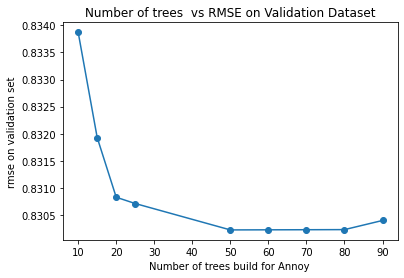

In [ ]:
plt.scatter(df['num_of_trees'],df['RMSE'])
plt.plot(df['num_of_trees'],df['RMSE'])
plt.title("Number of trees  vs RMSE on Validation Dataset")
plt.xlabel("Number of trees build for Annoy ")
plt.ylabel("rmse on validation set")
plt.show()

In [ ]:
df = df.sort_values(by='RMSE')
df

,num_of_trees,RMSE
4,50,0.830228
6,60,0.830230
7,70,0.830232
5,80,0.830234
8,90,0.830402
3,25,0.830714
2,20,0.830830
1,15,0.831930
0,10,0.833872


We find the optimum number of trees to be 50. Hence we now use n = 50 for training our Annoy ANN model to find user-user similarities

## Using ANN to Fill the User-Movie Matrix by taking hyperparameter n=50

In [ ]:
# Cross Join to Generate User - Movie Matrix
train_movies = train_df['movieId'].unique()
all_movies = pd.DataFrame(train_movies,columns=['movieId'])
all_movies['k'] = 0
all_users = pd.DataFrame(train_users,columns=['userId'])
all_users['k'] = 0
main_data = pd.merge(all_users,all_movies, on='k',how='outer').drop('k', axis=1)


In [ ]:
main_data = pd.merge(main_data,train_df, on=['userId','movieId'],how='left')
main_data = main_data[main_data['rating'].isnull()]

In [ ]:
len(main_data)

22506504

In [ ]:
a, b, c, d = np.split(main_data, 4)

In [ ]:
a[['userId','movieId']].to_csv('/data/a.csv',index=False)
b[['userId','movieId']].to_csv('/data/b.csv',index=False)
c[['userId','movieId']].to_csv('/data/c.csv',index=False)
d[['userId','movieId']].to_csv('/data/d.csv',index=False)

In [ ]:
def calc_raw_uid(inner_id):
  return trainset.to_raw_uid(inner_id)

In [ ]:
def calc_cosine(dist):
  return 1 - (dist/2)

In [ ]:
def filter_nn_user(nn_sim, movie_id,movie_to_users): 
    if nn_sim[0] in movie_to_users[movie_id]:
      return True
    return False

In [ ]:
def Ann_predictions_all(train, df, n):
  train_users = train['userId'].unique()
  train_df_pivoted = train.pivot(index='userId', columns='movieId', values='rating')

  avg_value = train_df_pivoted.mean(axis=1)
  user_mean_df = pd.DataFrame(avg_value,columns=['mean'])
  train_df_centered = train_df_pivoted.sub(train_df_pivoted.mean(axis=1), axis=0)

  movie_to_users = defaultdict(list)
  movie_to_users = train.groupby('movieId')['userId'].apply(list).to_dict()

  f = 15 # n_factors
  model_user_nn = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
  for i,u in zip(user_inner_ids,U):
      model_user_nn.add_item(i, u)

  model_user_nn.build(n) # n trees 
  # model_user_nn.save('test_user.ann')
  def find_nn(user_id):
    return model_user_nn.get_nns_by_item(trainset.to_inner_uid(user_id), 101, include_distances=True)
  
  l = list(map(find_nn,train_users))

  matrix_similarity_with_nn = {}

  for user_id,nn_dist in zip(train_users,l):
    matrix_similarity_with_nn[user_id] = [(nn,sim) for nn,sim in zip(list(map(calc_raw_uid,nn_dist[0]))[1:],list(map(calc_cosine,nn_dist[1]))[1:])]


  def predict_nn_rating(user_movie_pair):
    user_id, movie_id = user_movie_pair
    reduced_nn_sim = pd.DataFrame(filter(lambda x: filter_nn_user(x, movie_id, movie_to_users),matrix_similarity_with_nn[user_id]))
    prediction = user_mean_df.loc[user_id].values[0]

    if len(reduced_nn_sim)==0:
      return prediction

    u_list = reduced_nn_sim[0].to_list()
    nr = np.dot(train_df_centered.loc[u_list][movie_id],reduced_nn_sim[1])
    dr = np.sum(np.abs(reduced_nn_sim[1]))
    if(dr!=0):
      prediction += (nr/dr)
    return prediction


  preds = list(map(predict_nn_rating,[(user_id,movie_id) for user_id,movie_id in zip(df['userId'],df['movieId'])]))
  #rmse = np.sqrt(mean_squared_error(test['rating'],preds))
  return preds

df = pd.read_csv('/data/b.csv')
file_name = 'b'

t = np.array_split(df, 10)

for i  in range(0,10):
    p=t[i]
    p['predictions']=Ann_predictions_all(train_df, p, 50)
    p.to_csv('/data/'+file_name+'_'+str(i)+'.csv')
    

In [ ]:
t = pd.DataFrame(columns=['userId','movieId','predictions'])
for i in range(0,10):
  df = pd.read_csv('/data/'+'b_'+str(i)+'.csv') 
  t = pd.concat([t,df])

for i in range(0,10):
  df = pd.read_csv('/data/'+'a_'+str(i)+'.csv') 
  t = pd.concat([t,df])


for i in range(0,10):
  df = pd.read_csv('/data/'+'c_'+str(i)+'.csv') 
  t = pd.concat([t,df])

for i in range(0,10):
  df = pd.read_csv('/data/'+'d_'+str(i)+'.csv') 
  t = pd.concat([t,df])

In [ ]:
t.drop(columns= ['Unnamed: 0'],inplace=True)

In [ ]:
t.to_csv('/data/complete_predictions_ANN.csv',index=False)

In [ ]:
rating_preds = pd.merge(test_df,t,on=['userId','movieId'],how='inner')
rating_preds

,userId,movieId,rating,predictions
0,2,2243,4.5,3.651865
1,2,1186,3.5,4.072440
2,2,2707,3.5,3.139096
3,12,2302,2.5,2.883758
4,12,2012,1.5,3.165337
...,...,...,...,...
269241,283184,5621,1.0,1.496341
269242,283184,5971,4.5,4.416029
269243,283184,2863,4.0,4.362661
269244,283187,1298,4.0,3.204252


In [ ]:
Rmse_Ann = np.sqrt(mean_squared_error(rating_preds['rating'],rating_preds['predictions']))
print("The RMSE obtained is",Rmse_Ann)

The RMSE obtained is 0.9200872451353155
